# APOE ANALYZE WORKFOLW

Welcome to the quick start guide for AlphaGenome! The goal of this tutorial
notebook is to quickly get you started with using the model and making
predictions.

```{tip}
Open this tutorial in Google Colab for interactive viewing.
```

In [1]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

## Imports

In [2]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd

## Predict outputs for a DNA sequence

AlphaGenome is a model that makes predictions from DNA sequences. Let's load it
up:

```{tip}
If using Google Colab, store your key in "Secrets" for persistent access across sessions (see [installation](https://www.alphagenomedocs.com/installation.html#google-colab)). Otherwise, `dna_client.create` can take the API key directly.
```

In [3]:
dna_model = dna_client.create(colab_utils.get_api_key())

The model can make predictions for the following
[output types](https://www.alphagenomedocs.com/exploring_model_metadata.html):

In [4]:
[output.name for output in dna_client.OutputType]

['ATAC',
 'CAGE',
 'DNASE',
 'RNA_SEQ',
 'CHIP_HISTONE',
 'CHIP_TF',
 'SPLICE_SITES',
 'SPLICE_SITE_USAGE',
 'SPLICE_JUNCTIONS',
 'CONTACT_MAPS',
 'PROCAP']

`TrackData` objects have the following components:

<a href="https://services.google.com/fh/files/misc/trackdata.png"><img src="https://services.google.com/fh/files/misc/trackdata.png" alt="trackdata" border="0" height=500></a>

## Predict outputs for APOE genome interval (reference genome)

For convenience, you can also directly make predictions for a human reference
genome sequence specified by a **genomic interval**.

We first load up a GTF file containing gene and transcript locations as
annotated by GENCODE (more information on GTF format
[here](https://www.gencodegenes.org/pages/data_format.html)):

In [5]:
# The GTF file contains information on the location of all trancripts.
# Note that we use genome assembly hg38 for human.
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
# Mane select transcripts consists of of one curated transcript per locus.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_mane_select_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)

And then fetch the gene's location as a `genome.Interval` object by passing
either its `gene_symbol` (HGNC naming convention) or ENSEMBL `gene_id`:

In [6]:
interval = gene_annotation.get_gene_interval(gtf, gene_symbol='APOE')
interval

Interval(chromosome='chr19', start=44905790, end=44909393, strand='+', name='APOE')

We can resize it to a length compatible with the model:

In [7]:
interval = interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

The `.resize()` method adjusts the interval to the specified width by expanding
(or contracting) around its original center. Note that
`dna_model.predict_interval()` interprets this resizing as an expansion of the
actual genomic sequence rather than padding tokens.

In [8]:
interval.width

1048576

See the
[essential commands documentation](https://www.alphagenomedocs.com/colabs/essential_commands.html)
for more handy commands like `resize`.

Note that AlphaGenome supports the following input sequence lengths:

In [9]:
dna_client.SUPPORTED_SEQUENCE_LENGTHS.keys()

dict_keys(['SEQUENCE_LENGTH_16KB', 'SEQUENCE_LENGTH_100KB', 'SEQUENCE_LENGTH_500KB', 'SEQUENCE_LENGTH_1MB'])

We can now make predictions using our interval.

To characterize the tissue-specific regulatory architecture of the APOE locus using AlphaGenome, we employed a multi-modal selection of UBERON and Cell Ontology (CL) terms. We prioritized the Hippocampus (UBERON:0001954) and Dorsolateral Prefrontal Cortex (UBERON:0009834) as these regions represent the primary clinicopathological epicenters of Alzheimer's Disease, exhibiting early amyloid-β deposition and significant transcriptomic dysregulation. Recognizing that APOE serves as a dual-function lipid transporter, we integrated the Liver (UBERON:0002107) to capture the peripheral regulatory signals that govern systemic cholesterol metabolism. Furthermore, to refine AlphaGenome's predictions of chromatin accessibility and isoform-specific expression, we utilized cell-type-specific ontologies for Astrocytes (CL:0000127) and Microglia (CL:0000129). This approach ensures that the model interprets genetic variants within the specific epigenetic contexts of the primary cellular drivers of neuroinflammation and lipid transport, thereby maximizing the physiological relevance of the predicted functional impacts.

In [10]:
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0009834', # DLPFC (Brain)
    'UBERON:0001954', # Hippocampus (Brain)
    'UBERON:0002107', # Liver (Peripheral)
    'CL:0000127']      # Astrocytes (Cell type),
)

output.rna_seq.values.shape

(1048576, 11)

In general, you can have multiple tracks for a given ontology term. In this
case, we have 3 RNA-seq tracks for the tissue "Right liver lobe".

Let's visualise these predictions. It's helpful visualise gene transcripts
alongside the predicted tracks, so we extract them here:

In [11]:
transcripts = transcript_extractor.extract(interval)
print(f'Extracted {len(transcripts)} transcripts in this interval.')

Extracted 34 transcripts in this interval.


We also provide a
[visualization basics guide](https://www.alphagenomedocs.com/visualization_library_basics.html)
that integrates nicely with `TrackData` and other objects returned by the model
API.

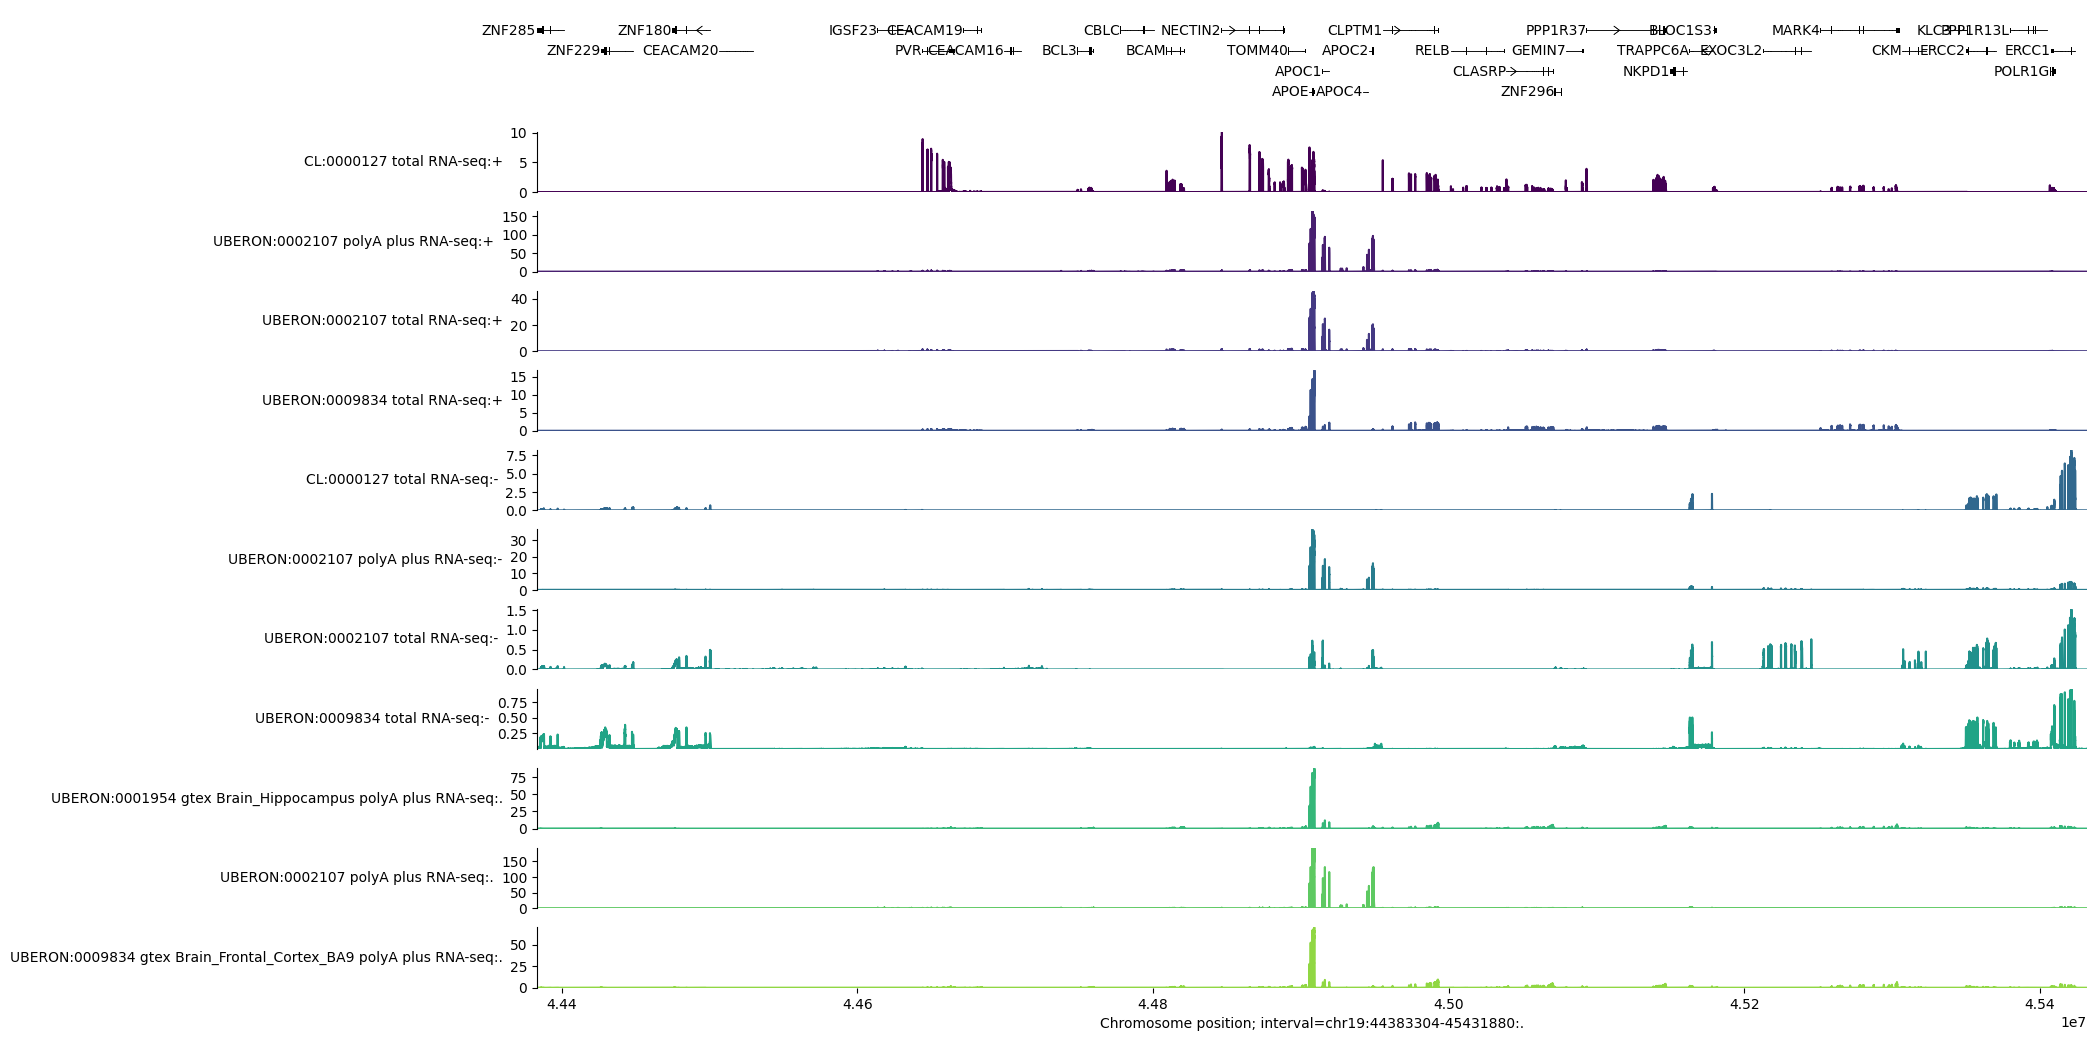

In [12]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(transcripts),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval,
)

plt.show()

This plot visualises the 3 predicted RNA-seq tracks and also marks the location
of the MANE select transcript per gene in the 1MB region.

We can zoom in to the middle of the plot by resizing the interval:

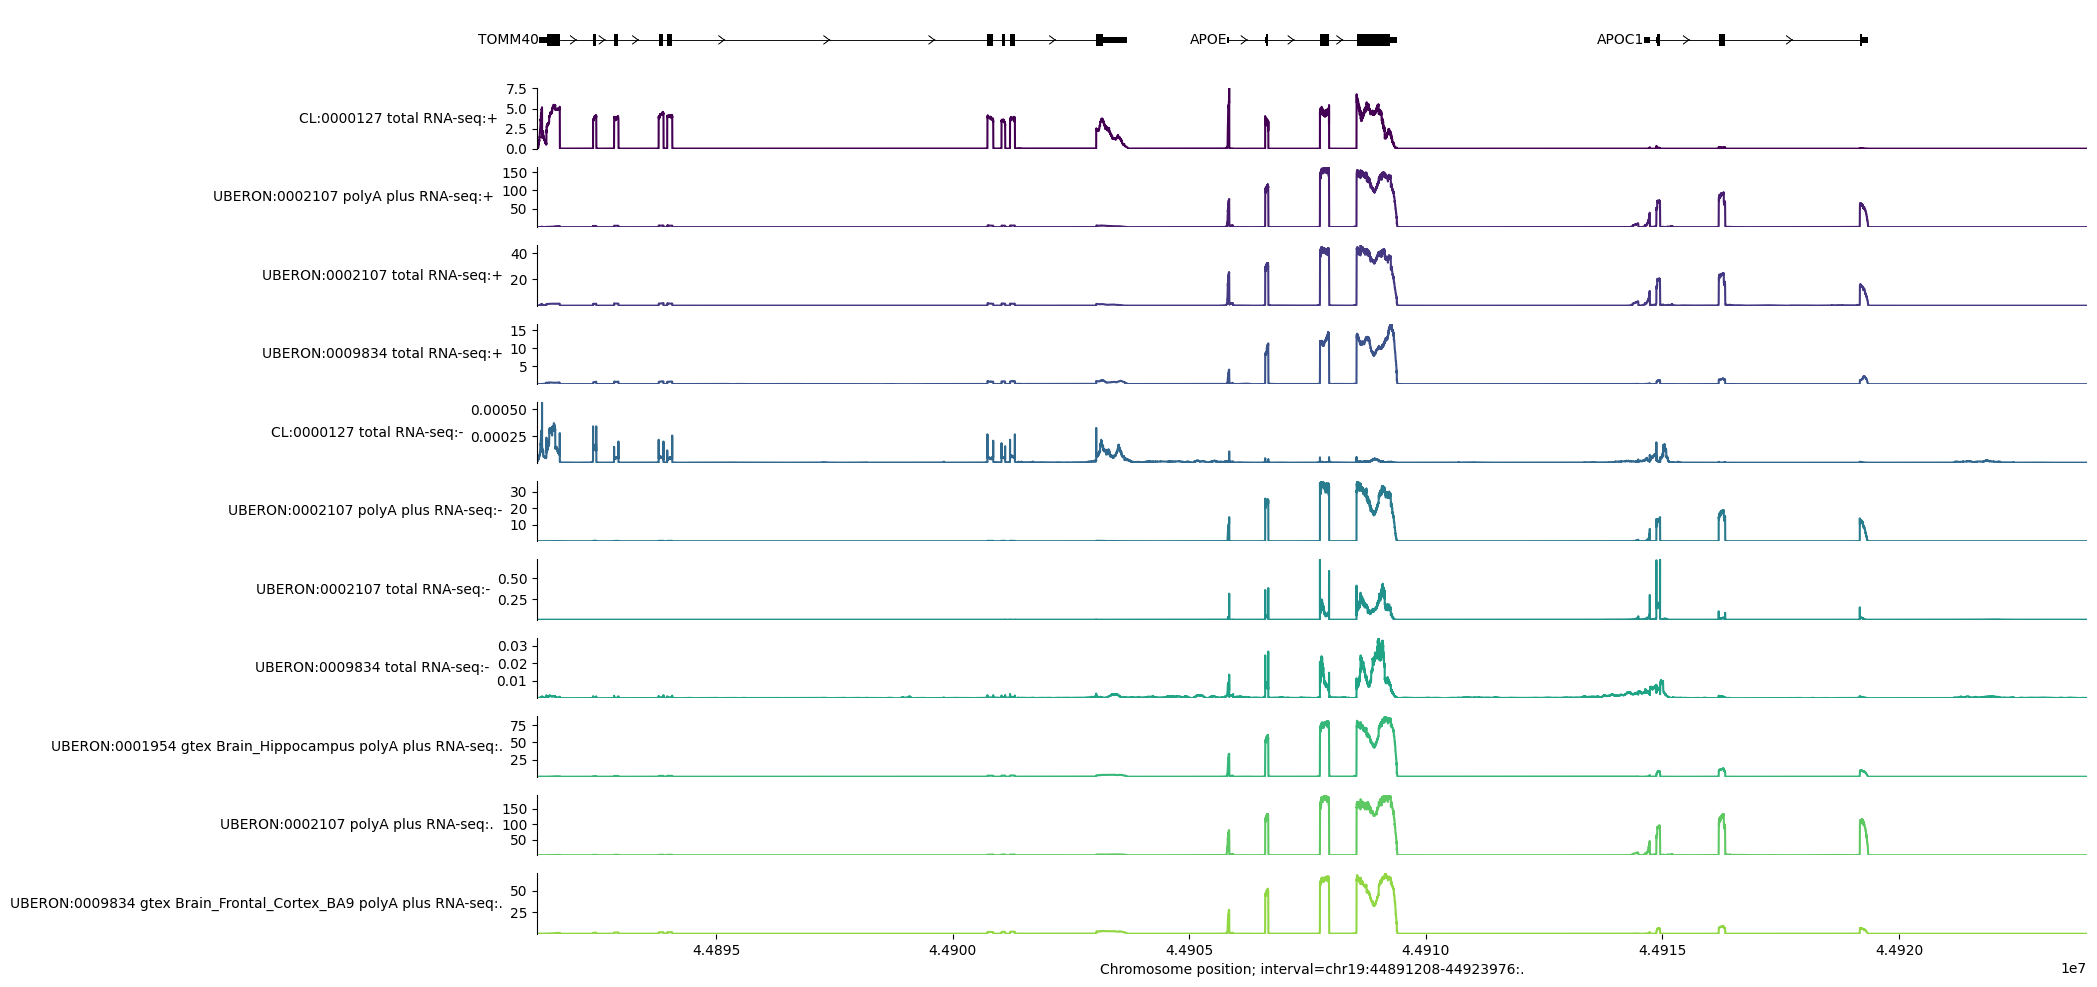

In [13]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(
            transcripts, fig_height=0.1
        ),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval.resize(2**15),
)

plt.show()

You can see here that predicted RNA-seq values are nicely aligned with the
location of exons, and that the predictions are stranded – the predicted values
are much higher for the positive strand, where the gene is located. We see that
the *CYP2B6* gene is on the positive strand since the arrows in the transcript
go from left to right.

For more detail on the visualization library, please refer to the
[visualization basics guide](https://www.alphagenomedocs.com/visualization_library_basics.html)
and
[library documentation](https://www.alphagenomedocs.com/api/visualization.html).

## Predict variant effects

We can predict the effect of a variant on a specific output type and tissue by
making predictions for the reference (REF) and alternative (ALT) allele
sequences.

We specify the variant by defining a `genome.Variant` object. The specific
variant below is a known variant affecting gene expression in colon tissue:

In [14]:
variant = genome.Variant(
    chromosome='chr19',
    position=44908684,  # rs429358, cause APOE3 -> APOE4
    reference_bases='T',  # Can differ from the true reference genome base.
    alternate_bases='C',
)

Next, we define the interval over which to make the REF and ALT predictions. A
quick way to get a `genome.Interval` from a `genome.Variant` is by calling
`.reference_interval`, which we can resize to a model-compatible sequence
length:

In [18]:
#interval = variant.reference_interval.resize(dna_client.SEQUENCE_LENGTH_1MB)
interval = gene_annotation.get_gene_interval(gtf, gene_symbol='APOE')
interval = interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

We then use `predict_variant` to get the REF and ALT RNA-seq predictions in the interval for "DLPFC", "Hippocampus", "Liver", "Astrocytes" tissues:

In [19]:
variant_output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0009834', # DLPFC (Brain)
    'UBERON:0001954', # Hippocampus (Brain)
    'UBERON:0002107', # Liver (Peripheral)
    'CL:0000127']      # Astrocytes (Cell type),
)  # Colon - Transverse.

We can plot the predicted REF and ALT values as a single plot and zoom in on the
affected gene to better visualise the variant's effect on gene expression:

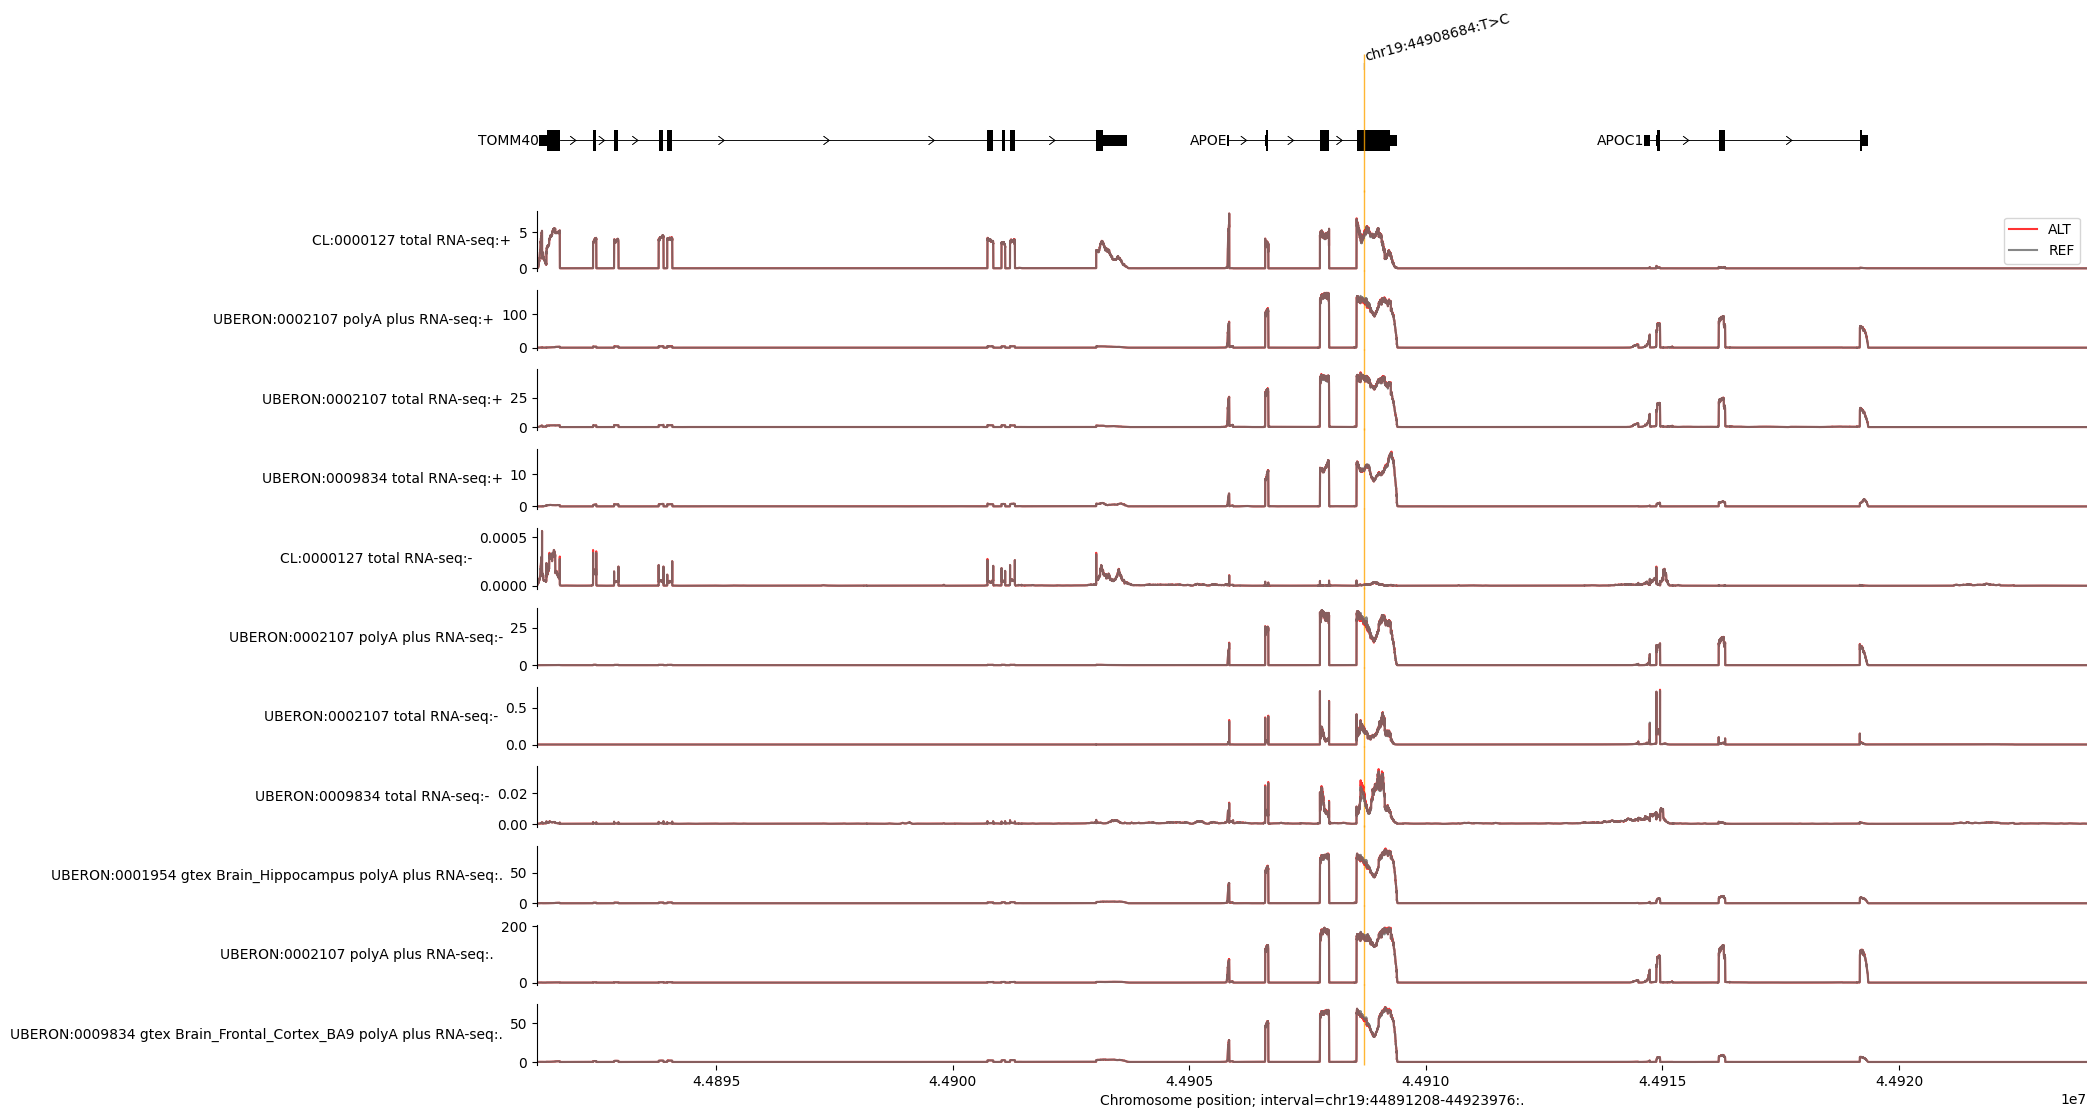

In [20]:
transcripts = transcript_extractor.extract(interval)

plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),
        plot_components.OverlaidTracks(
            tdata={
                'REF': variant_output.reference.rna_seq,
                'ALT': variant_output.alternate.rna_seq,
            },
            colors={'REF': 'dimgrey', 'ALT': 'red'},
        ),
    ],
    interval=variant_output.reference.rna_seq.interval.resize(2**15),
    # Annotate the location of the variant as a vertical line.
    annotations=[plot_components.VariantAnnotation([variant], alpha=0.8)],
)
plt.show()

It seems no significant changes in the transcriptomics in rs429358.

## Scoring the effect of rs429358.

Scoring the effect of a genetic variant involves making predictions for the REF
and ALT sequences and aggregating the track signal. This is implemented in
`score_variant`, which uses specific `variant_scorer` configs for aggregation.

We provide a set of recommended variant scoring configurations as a dictionary
(`variant_scorers.RECOMMENDED_VARIANT_SCORERS`), covering all output types,
which we have assessed for their performance at domain-specific tasks. See the
[variant scoring documentation](https://www.alphagenomedocs.com/variant_scoring.html)
for more information. Here is a quick demo:

In [21]:
variant_scorer = variant_scorers.RECOMMENDED_VARIANT_SCORERS['RNA_SEQ']

variant_scores = dna_model.score_variant(
    interval=interval, variant=variant, variant_scorers=[variant_scorer]
)

The returned `variant_scores` is a list of length 1 because we only specified 1
scorer:

In [22]:
len(variant_scores)

1

The actual scores per variant are in `AnnData` format, which is a way of
annotating data (the numerical scores) with additional information about the
rows and columns.

In [23]:
variant_scores = variant_scores[0]
variant_scores

AnnData object with n_obs × n_vars = 61 × 667
    obs: 'gene_id', 'strand', 'gene_name', 'gene_type'
    var: 'name', 'strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'biosample_life_stage', 'gtex_tissue', 'data_source', 'endedness', 'genetically_modified', 'nonzero_mean'
    uns: 'interval', 'variant', 'variant_scorer'
    layers: 'quantiles'

`AnnData` objects have the following components:

<a href="https://services.google.com/fh/files/misc/anndata.png"><img src="https://services.google.com/fh/files/misc/anndata.png" alt="anndata" border="0" height=500></a>

We have a variant effect score for each of the 37 genes in the interval and each
of the 667 `RNA_SEQ` tracks:

In [24]:
variant_scores.X.shape

(61, 667)

We can access information on the 37 genes using `.obs`. Here are just first 5
genes:

In [26]:
variant_scores.obs.head()

,gene_id,strand,gene_name,gene_type
0,ENSG00000007047.16,+,MARK4,protein_coding
1,ENSG00000007255.10,-,TRAPPC6A,protein_coding
2,ENSG00000012061.17,-,ERCC1,protein_coding
3,ENSG00000069399.15,+,BCL3,protein_coding
4,ENSG00000073008.16,+,PVR,protein_coding


Note that if you are using a variant scorer that is not gene-specific (i.e., a
`variant_scorers.CenterMaskScorer`), then `variant_scores.X` would have shape
`(1, 667)` and there will be no gene metadata available since there is no
concept of genes in this scenario.

The description of each track is accessed using `.var` (this is the same
dataframe as the output metadata, but is included alongside the variant scores
for convenience):

In [27]:
variant_scores.var

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified,nonzero_mean
0,CL:0000047 polyA plus RNA-seq,+,polyA plus RNA-seq,CL:0000047,neuronal stem cell,in_vitro_differentiated_cells,embryonic,,encode,paired,False,0.143617
1,CL:0000062 total RNA-seq,+,total RNA-seq,CL:0000062,osteoblast,primary_cell,adult,,encode,paired,False,0.094144
2,CL:0000084 polyA plus RNA-seq,+,polyA plus RNA-seq,CL:0000084,T-cell,primary_cell,adult,,encode,paired,False,0.124296
3,CL:0000084 total RNA-seq,+,total RNA-seq,CL:0000084,T-cell,primary_cell,adult,,encode,single,False,0.100934
4,CL:0000115 total RNA-seq,+,total RNA-seq,CL:0000115,endothelial cell,in_vitro_differentiated_cells,adult,,encode,single,False,0.135553
...,...,...,...,...,...,...,...,...,...,...,...,...
662,UBERON:0018115 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018115,left renal pelvis,tissue,embryonic,,encode,single,False,0.268222
663,UBERON:0018116 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018116,right renal pelvis,tissue,embryonic,,encode,single,False,0.258522
664,UBERON:0018117 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018117,left renal cortex interstitium,tissue,embryonic,,encode,single,False,0.215190
665,UBERON:0018118 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018118,right renal cortex interstitium,tissue,embryonic,,encode,single,False,0.365676


Some handy additional metadata can be found in `.uns`:

In [28]:
print(f'Interval: {variant_scores.uns["interval"]}')
print(f'Variant: {variant_scores.uns["variant"]}')
print(f'Variant scorer: {variant_scores.uns["variant_scorer"]}')

Interval: chr19:44383304-45431880:+
Variant: chr19:44908684:T>C
Variant scorer: GeneMaskLFCScorer(requested_output=RNA_SEQ)


We recommend interacting with variant scores by flattening `AnnData` objects
using `tidy_scores`, which produces a dataframe with each row being a single
score for each combination of (variant, gene, scorer, ontology). It optionally
excludes stranded tracks which do not match the gene’s strand for gene-specific
scorer.

The `raw_score` column contains the same values as stored in `variant_scores.X`.
The `quantile_score` column is the rank of the `raw_score` in the distribution
of scores for a background set of common variants, represented as a quantile
probability. This allows for direct comparison across variant scoring strategies
that yield scores on different scales. See
[FAQs](https://www.alphagenomedocs.com/faqs.html#what-is-the-difference-between-a-quantile-score-and-raw-score)
for further details.

In [95]:

variant_scorers.tidy_scores([variant_scores], match_gene_strand=True)

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,...,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified,raw_score,quantile_score
0,chr19:44908684:T>C,chr19:44384396-45432972:.,ENSG00000007047,MARK4,protein_coding,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000047,neuronal stem cell,in_vitro_differentiated_cells,embryonic,,encode,paired,False,0.001487,0.781719
1,chr19:44908684:T>C,chr19:44384396-45432972:.,ENSG00000007047,MARK4,protein_coding,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000062,osteoblast,primary_cell,adult,,encode,paired,False,0.000247,0.494645
2,chr19:44908684:T>C,chr19:44384396-45432972:.,ENSG00000007047,MARK4,protein_coding,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000084,T-cell,primary_cell,adult,,encode,paired,False,0.000228,0.343112
3,chr19:44908684:T>C,chr19:44384396-45432972:.,ENSG00000007047,MARK4,protein_coding,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000084,T-cell,primary_cell,adult,,encode,single,False,0.000434,0.449849
4,chr19:44908684:T>C,chr19:44384396-45432972:.,ENSG00000007047,MARK4,protein_coding,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,CL:0000115,endothelial cell,in_vitro_differentiated_cells,adult,,encode,single,False,0.000844,0.648619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24151,chr19:44908684:T>C,chr19:44384396-45432972:.,ENSG00000291128,APOC1P1,lncRNA,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,UBERON:0018115,left renal pelvis,tissue,embryonic,,encode,single,False,-0.012218,-0.998029
24152,chr19:44908684:T>C,chr19:44384396-45432972:.,ENSG00000291128,APOC1P1,lncRNA,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,UBERON:0018116,right renal pelvis,tissue,embryonic,,encode,single,False,-0.012772,-0.998118
24153,chr19:44908684:T>C,chr19:44384396-45432972:.,ENSG00000291128,APOC1P1,lncRNA,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,UBERON:0018117,left renal cortex interstitium,tissue,embryonic,,encode,single,False,-0.013369,-0.998284
24154,chr19:44908684:T>C,chr19:44384396-45432972:.,ENSG00000291128,APOC1P1,lncRNA,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),...,UBERON:0018118,right renal cortex interstitium,tissue,embryonic,,encode,single,False,-0.012098,-0.997888
